# Test the compton upscattering

... by starting with a gaussian distribution scattering on an electron distribution of higher temperature.
Energy is conserved in the system.

In [1]:
%reset
import numpy as np
import sys
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy.integrate import simps, trapz

%run constants.ipynb
sys.path.append('../src/')
from core import SimulationManager

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


### Pre-run functionalities: Calculate Grid parameters from minimum and maximum energy

In [2]:
def calculate_grid_parameters(xmin, xmax, ulim_lastbin):
    D_X = np.log(1/(1-ulim_lastbin/xmax))
    X_I = np.log(xmin)/D_X
    BIN_X = np.log(xmax)/D_X - X_I
    return D_X, int(X_I), int(BIN_X)

In [3]:
def calculate_grid_parameters_DX(xmin, xmax, D_X):
    X_I = np.log(xmin)/D_X
    BIN_X = np.log(xmax)/D_X - X_I
    return int(X_I), int(BIN_X)

# Run the simulation

## Grid settings

In [4]:
delta_t = 5.e-11

In [5]:
D_X = 2.e-2
xmin = 1.e-9
xmax = 1.e1
X_I, BIN_X = calculate_grid_parameters_DX(xmin, xmax, D_X)

In [6]:
grid_parameters = {'BIN_X':BIN_X, 'D_X':D_X, 'X_I':X_I, 'type_grid' : 'log'}
solver_settings = {'include_kompaneets': True, 'kompaneets_extended_by': 'none', 'CN_solver': False }

## Initialize simulation and set parameters

In [7]:
sim = SimulationManager(grid_parameters, delta_t, solver_settings)

In [8]:
initial_array = np.zeros(BIN_X)

In [9]:
T = 10.e3/ k_B_eV

In [10]:
sim.source_parameters['T'] = T *k_B_erg/ m_e/c0**2
sim.source_parameters['n_e'] =6.e22
#sim.delta_t = 1.e-2 /(sim.source_parameters['n_e']*sigma_t*c0)

## Define initial gaussian distribution 

In [11]:
energygrid = sim.energygrid

In [12]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [13]:
def gaussian(x, width, midpoint):
    res = 1/(width*np.sqrt(np.pi*2))*np.exp(-0.5*((x - midpoint)/width)**2)
    return res

In [14]:
idx = find_nearest(sim.energygrid, 500/(511.e3))
midpoint = idx
width = 3 # gridpoints, not energy
for i in range(BIN_X):
    initial_array[i] = 1.e3*gaussian(i, width, midpoint)


## Initialize run with initial array, add modules

In [15]:
sim.initialise_run(initial_array)
modules = []
sim.reset_modules(modules)

## Check the grid and the initial configurations

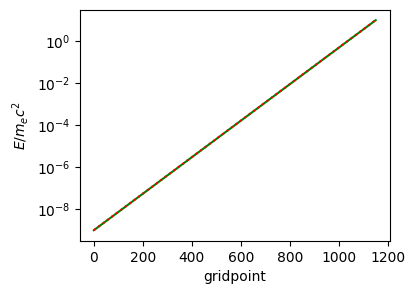

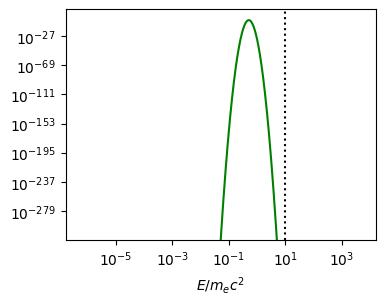

In [16]:
# Grid and Half-Grid
fig = plt.figure(figsize = [4,3])
ax = plt.gca()

ax.plot(sim.energygrid, color = 'g')
ax.plot(sim.half_grid, ls = ':', color = 'r')
ax.set(yscale = 'log',
     ylabel = r'$E/m_e c^2$', 
      xlabel = 'gridpoint')

plt.show()


# Initial photons and electron temperature
fig = plt.figure(figsize = [4,3])
ax = plt.gca()

ax.plot(sim.energygrid*511, initial_array*sim.energygrid**2, c = 'g')
ax.axvline(sim.source_parameters['T']*511, c = 'k', ls = ':')
ax.set(yscale = 'log', xscale='log', 
      xlabel = r'$E/m_e c^2$')
plt.show()


## Initial energy budgets

In [19]:
arr_to_integrate = sim.energygrid**3*sim.photonarray
E_photons = 8* np.pi * (m_e*c0**2)**4/(c0*h)**3 *simps(arr_to_integrate, sim.energygrid)
print(E_photons)

E_ele = 3/2 * T *k_B_erg*sim.source_parameters['n_e']
print(E_ele)

28235260758796.934
1441958970624292.5


In [20]:
sim.compute_E_total()
E_photons_curr = sim.E
E_ele_curr = E_ele

In [21]:
Etot = E_ele + E_photons

## Run the simulations

In [22]:
photon_temp_evolution = []
ele_temp_evolution = []


In [23]:

for j in range(8):
    for k in range(500):
        
        
        sim.evolve_one_timestep()
        
        E_ele_curr = Etot - sim.E
        T_e = E_ele_curr*2/3. /sim.source_parameters['n_e']
        sim.T = T_e/m_e/c0**2
        
        #dE_dt = calculate_dE_dt(sim)
        #sim.source_parameters['T'] -= dE_dt * sim.delta_t * 2/3 / sim.source_parameters['n_e']/m_e/c0**2
        
        print(k, sim.source_parameters['T'])
        clear_output(wait=True)
        
        ele_temp_evolution.append(sim.T)
        photon_temp_evolution.append(sim.photonarray)


499 0.01956951183606842


### Check the final energies

In [24]:
arr_to_integrate = sim.energygrid**3*sim.photonarray
E_photons = 8* np.pi * (m_e*c0**2)**4/(c0*h)**3 *trapz(arr_to_integrate, sim.energygrid)
print(E_photons)
E_ele = 3/2 * sim.source_parameters['T'] * k_B_erg*sim.source_parameters['n_e']
print(E_ele)


1654827764308619.2
243167.6425226043


# Plot

## Photon spectra
### Time evolution

In [25]:
colors = sns.color_palette('BuPu', int(len(photon_temp_evolution)/1))
norm2 = matplotlib.colors.Normalize(vmin=0, vmax=sim.time/1)

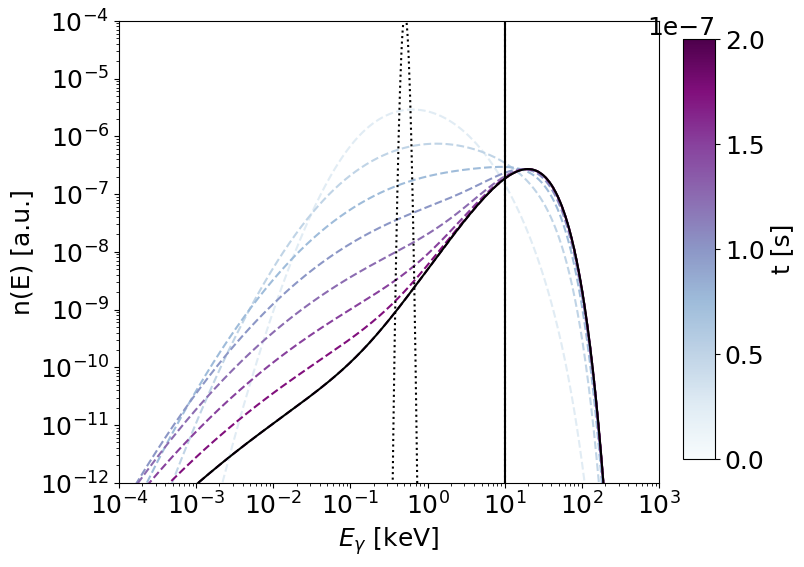

In [29]:
matplotlib.rcParams.update({'font.size': 18})

fig = plt.figure(figsize = [8, 6])


ax = plt.gca()

for j in range(8):
    k = j*500-1
    ax.plot(sim.energygrid*511, photon_temp_evolution[k]*sim.energygrid**2,
             ls = '--', c = colors[k])
    
ax.plot(sim.energygrid*511, sim.photonarray*sim.energygrid**2, color = 'k') # final photon distribution
ax.plot(sim.energygrid*511, initial_array*sim.energygrid**2, ls = ':', color = 'k') # initial photon distribution

ax.axvline(10., color = 'k', ls = ':') # initial electron temperature
ax.axvline(sim.source_parameters['T']*511, color = 'k', ls = '-') # final electron temperature 

ax.set(yscale = 'log', xscale = 'log', 
       xlim = [1.e-4, 1.e3], ylim = [1.e-12, 1.e-4],
      xlabel =r'$E_{\gamma}$ [keV]',
      ylabel = 'n(E) [a.u.]')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.04, 0.7])
matplotlib.colorbar.ColorbarBase(cbar_ax, cmap='BuPu', norm = norm2, label = 't [s]')

plt.show()

### Full-range specta

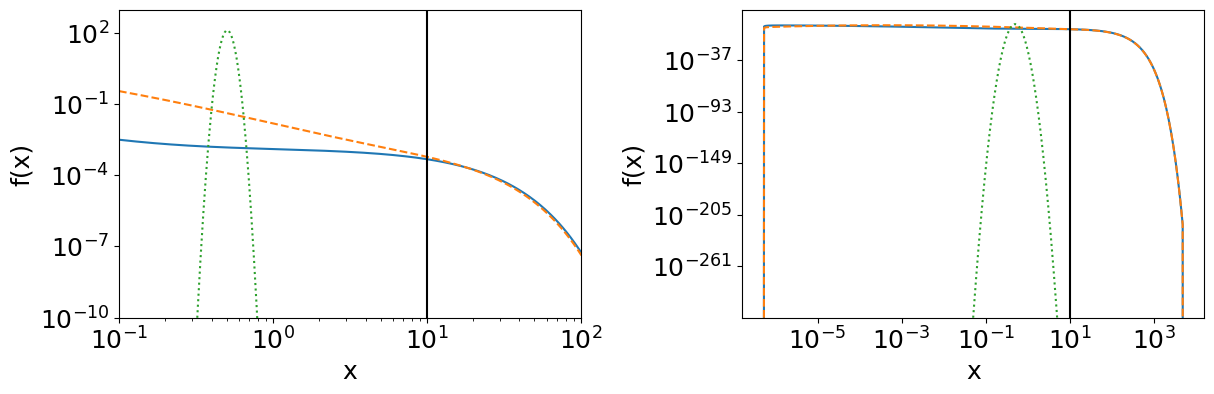

In [27]:
k_half = int(len(photon_temp_evolution)/2)
fig, axes = plt.subplots(1,2, figsize = [14, 4])
plt.subplots_adjust(wspace = 0.35)
ax = axes[0]
ax.plot(sim.energygrid*511, sim.photonarray)
ax.plot(sim.energygrid*511, photon_temp_evolution[k_half], ls = '--')

ax.plot(sim.energygrid*511, initial_array, ls = ':')
ax.axvline(sim.source_parameters['T'] *511, color = 'k')
ax.set(yscale = 'log', xscale = 'log', 
       xlim = [1.e-1, 1.e2], ylim = [1.e-10, 1.e3], 
        xlabel = 'x', ylabel = 'f(x)')


ax = axes[1]

ax.plot(sim.energygrid*511, sim.photonarray)
ax.plot(sim.energygrid*511, photon_temp_evolution[k_half], ls = '--')

ax.plot(sim.energygrid*511, initial_array, ls = ':')
ax.axvline(sim.source_parameters['T'] *511, color = 'k')
ax.set(yscale = 'log', xscale = 'log', xlabel = 'x', ylabel = 'f(x)')

#ax.set(yscale = 'log', xscale = 'log', xlim = [1.e-12, 1.e3], ylim = [1.e-14, 1.e3])
plt.show()